## **SÉRIE TEMPORAL CNTR - VIAGEM DE CINEMA COM TRANSFORMER**

In [1]:
# Importando pacotes
import torch
import sklearn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [2]:
dados_originais = pd.read_csv('dados/VC-ST_mes.csv', sep=';')
dados_originais.head()

,Meses,#Acessos
0,2010-06-01,33
1,2010-07-01,244
2,2010-08-01,166
3,2010-09-01,196
4,2010-10-01,347


In [3]:
dados_originais["Meses"] = pd.to_datetime(dados_originais["Meses"], format="%Y-%m-%d")
dados_originais.set_index("Meses", inplace = True)
dados_originais.head()

,#Acessos
Meses,
2010-06-01,33
2010-07-01,244
2010-08-01,166
2010-09-01,196
2010-10-01,347


In [4]:
trn = dados_originais.loc[dados_originais.index < '2022-03-01']
tst = dados_originais.loc[dados_originais.index >= '2022-03-01']
tst.tail()

,#Acessos
Meses,
2022-10-01,5825
2022-11-01,7269
2022-12-01,5065
2023-01-01,5106
2023-02-01,6601


In [5]:
# Dica: Uma vez que a coluna a ser analisada (acessos) está ordenada, não é necessário usar a coluna de data
arquivo = "dados/VC-ST_mes.csv"
df = pd.read_csv(arquivo, sep= ";", usecols = [1], engine = 'python')
df.head()

,#Acessos
0,33
1,244
2,166
3,196
4,347


In [6]:
df.describe()

,#Acessos
count,153.000000
mean,7183.326797
std,5994.375078
min,33.000000
25%,3818.000000
50%,5457.000000
75%,7941.000000
max,38726.000000


<AxesSubplot:>

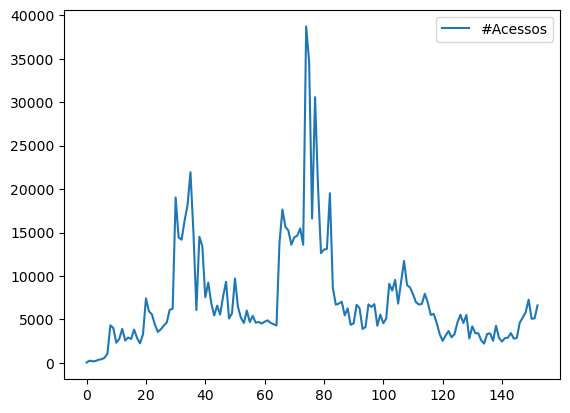

In [7]:
# Plot
df.plot()

In [8]:
# Converte os dados para float32 a fim de melhorar a precisão dos cálculos
dataset = df.values.astype('float32')

In [9]:
# Amostra dos dados
dataset[0:4]

array([[ 33.],
       [244.],
       [166.],
       [196.]], dtype=float32)

### Pré-Processamento

In [10]:
# Colocando os dados na mesma escala (entre 0 e 1)
scaler = MinMaxScaler(feature_range = (0, 1))

In [11]:
# Fit e transform nos dados padronizados
dataset = scaler.fit_transform(dataset)

In [12]:
len(dataset)

153

In [13]:
# Divide os dados em amostras de treino e teste seguindo a ordem dos dados no conjunto de dados
# Proporções adequadas a uma janela de 12 meses
tamanho_treino = int(len(dataset) * 0.67)
test_size = len(dataset) - tamanho_treino
dados_treino, dados_teste = dataset[0:tamanho_treino], dataset[tamanho_treino:]

In [14]:
len(dados_treino)

102

In [15]:
len(dados_teste)

51

In [16]:
# Função para criar os datasets de treino e teste
def create_dataset(data, window_size):
    
    # Listas de X (entrada) e Y (saída)
    X, Y = [], []
    
    # Loop para criar X (11 elementos de input) e Y (1 elemento de label)
    for i in range(len(data) - window_size - 1):
        a = data[i:(i + window_size), 0]
        X.append(a)
        Y.append(data[i + window_size, 0])
    
    return np.array(X), np.array(Y)

In [17]:
# Tamanho da janela
window_size = 12

In [18]:
# Cria os datasets de treino e teste
X_treino, Y_treino = create_dataset(dados_treino, window_size)
X_teste, Y_teste = create_dataset(dados_teste, window_size)

In [19]:
X_treino

array([[0.        , 0.00545318, 0.00343731, ..., 0.1022924 , 0.05874448,
        0.07006435],
       [0.00545318, 0.00343731, 0.00421265, ..., 0.05874448, 0.07006435,
        0.09988887],
       [0.00343731, 0.00421265, 0.00811516, ..., 0.07006435, 0.09988887,
        0.0653865 ],
       ...,
       [0.18078206, 0.1401804 , 0.16077843, ..., 0.17295119, 0.16524953,
        0.17357145],
       [0.1401804 , 0.16077843, 0.11206162, ..., 0.16524953, 0.17357145,
        0.10924457],
       [0.16077843, 0.11206162, 0.1163518 , ..., 0.17357145, 0.10924457,
        0.14248055]], dtype=float32)

In [20]:
Y_treino

array([0.09988887, 0.0653865 , 0.07422531, 0.06990929, 0.09782132,
       0.07280387, 0.05696121, 0.08399452, 0.19068049, 0.15230146,
       0.14304914, 0.11301786, 0.09092084, 0.09859665, 0.10950302,
       0.11898793, 0.15659164, 0.1602357 , 0.49117413, 0.37210867,
       0.36528572, 0.42095473, 0.46770737, 0.56617475, 0.38784796,
       0.15597136, 0.374383  , 0.34592822, 0.19406612, 0.23769158,
       0.17706046, 0.13976689, 0.16930711, 0.14245471, 0.19685732,
       0.24027602, 0.13085054, 0.14635722, 0.24981265, 0.16574058,
       0.13320239, 0.11748896, 0.1544207 , 0.12048692, 0.13862973,
       0.11836766, 0.12059029, 0.11578322, 0.12133978, 0.12534568,
       0.11800584, 0.11410333, 0.1100199 , 0.35564575, 0.4553537 ,
       0.40330294, 0.39278424, 0.35047686, 0.37239295, 0.37748432,
       0.398806  , 0.35045102, 1.0000001 , 0.8959502 , 0.42839792,
       0.7897811 , 0.52203244, 0.32545942, 0.3359264 , 0.3381232 ,
       0.5038121 , 0.2217197 , 0.17186572, 0.17519966, 0.18078

In [21]:
# Converte tudo de array NumPy para tensor PyTorch
X_treino = torch.from_numpy(X_treino).float()
Y_treino = torch.from_numpy(Y_treino).float()
X_teste = torch.from_numpy(X_teste).float()
Y_teste = torch.from_numpy(Y_teste).float()

In [22]:
X_treino

tensor([[0.0000, 0.0055, 0.0034,  ..., 0.1023, 0.0587, 0.0701],
        [0.0055, 0.0034, 0.0042,  ..., 0.0587, 0.0701, 0.0999],
        [0.0034, 0.0042, 0.0081,  ..., 0.0701, 0.0999, 0.0654],
        ...,
        [0.1808, 0.1402, 0.1608,  ..., 0.1730, 0.1652, 0.1736],
        [0.1402, 0.1608, 0.1121,  ..., 0.1652, 0.1736, 0.1092],
        [0.1608, 0.1121, 0.1164,  ..., 0.1736, 0.1092, 0.1425]])

In [23]:
Y_treino

tensor([0.0999, 0.0654, 0.0742, 0.0699, 0.0978, 0.0728, 0.0570, 0.0840, 0.1907,
        0.1523, 0.1430, 0.1130, 0.0909, 0.0986, 0.1095, 0.1190, 0.1566, 0.1602,
        0.4912, 0.3721, 0.3653, 0.4210, 0.4677, 0.5662, 0.3878, 0.1560, 0.3744,
        0.3459, 0.1941, 0.2377, 0.1771, 0.1398, 0.1693, 0.1425, 0.1969, 0.2403,
        0.1309, 0.1464, 0.2498, 0.1657, 0.1332, 0.1175, 0.1544, 0.1205, 0.1386,
        0.1184, 0.1206, 0.1158, 0.1213, 0.1253, 0.1180, 0.1141, 0.1100, 0.3556,
        0.4554, 0.4033, 0.3928, 0.3505, 0.3724, 0.3775, 0.3988, 0.3505, 1.0000,
        0.8960, 0.4284, 0.7898, 0.5220, 0.3255, 0.3359, 0.3381, 0.5038, 0.2217,
        0.1719, 0.1752, 0.1808, 0.1402, 0.1608, 0.1121, 0.1164, 0.1715, 0.1618,
        0.0997, 0.1055, 0.1730, 0.1652, 0.1736, 0.1092, 0.1425, 0.1166])

In [24]:
X_teste

tensor([[0.2342, 0.2138, 0.2459, 0.1753, 0.2401, 0.3019, 0.2306, 0.2233, 0.2037,
         0.1797, 0.1724, 0.1742],
        [0.2138, 0.2459, 0.1753, 0.2401, 0.3019, 0.2306, 0.2233, 0.2037, 0.1797,
         0.1724, 0.1742, 0.2044],
        [0.2459, 0.1753, 0.2401, 0.3019, 0.2306, 0.2233, 0.2037, 0.1797, 0.1724,
         0.1742, 0.2044, 0.1783],
        [0.1753, 0.2401, 0.3019, 0.2306, 0.2233, 0.2037, 0.1797, 0.1724, 0.1742,
         0.2044, 0.1783, 0.1414],
        [0.2401, 0.3019, 0.2306, 0.2233, 0.2037, 0.1797, 0.1724, 0.1742, 0.2044,
         0.1783, 0.1414, 0.1447],
        [0.3019, 0.2306, 0.2233, 0.2037, 0.1797, 0.1724, 0.1742, 0.2044, 0.1783,
         0.1414, 0.1447, 0.1178],
        [0.2306, 0.2233, 0.2037, 0.1797, 0.1724, 0.1742, 0.2044, 0.1783, 0.1414,
         0.1447, 0.1178, 0.0844],
        [0.2233, 0.2037, 0.1797, 0.1724, 0.1742, 0.2044, 0.1783, 0.1414, 0.1447,
         0.1178, 0.0844, 0.0644],
        [0.2037, 0.1797, 0.1724, 0.1742, 0.2044, 0.1783, 0.1414, 0.1447, 0.1178,

In [25]:
Y_teste

tensor([0.2044, 0.1783, 0.1414, 0.1447, 0.1178, 0.0844, 0.0644, 0.0798, 0.0936,
        0.0750, 0.0839, 0.1193, 0.1421, 0.1175, 0.1414, 0.0713, 0.1075, 0.0871,
        0.0870, 0.0656, 0.0563, 0.0847, 0.0867, 0.0645, 0.1095, 0.0733, 0.0622,
        0.0724, 0.0738, 0.0875, 0.0711, 0.0730, 0.1185, 0.1337, 0.1497, 0.1870,
        0.1300, 0.1311])

### Construção de data loaders

In [26]:
# Classe para criação do dataset da série temporal (para organizar os dados)
class TimeSeriesDataset(Dataset):
    
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [27]:
# Cria os TimeSeriesDatasets
train_dataset = TimeSeriesDataset(X_treino, Y_treino)
test_dataset = TimeSeriesDataset(X_teste, Y_teste)

In [28]:
# Cria os dataloaders
train_loader = DataLoader(train_dataset, batch_size = 1, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

### Modelo Transformer

In [29]:
# ARQUITETURA DO MODELO
# Cria a classe do modelo
class TimeSeriesTransformer(nn.Module):
    
    # Método construtor (inicializa os elementos)
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout = 0.1):
        
        super().__init__()
        
        self.embedding = nn.Linear(input_dim, model_dim)
        
        self.encoder_layer = nn.TransformerEncoderLayer(d_model = model_dim, nhead = num_heads, dropout = dropout)
        
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers = num_layers)
        
        self.linear = nn.Linear(model_dim, 1)

    # Método forward (executa para fazer a previsão pelo modelo)
    def forward(self, x):
        
        x = self.embedding(x)
        
        x = x.permute(1, 0, 2)  
        
        x = self.transformer_encoder(x)
        
        x = self.linear(x)
        
        x = x.permute(1, 0, 2)
        
        return x[:, -1, :]

### Hiperparâmetros, função de erro e otimizador

In [30]:
# Hiperparâmetros (input_dim = 1 porque só temos 1 variável) 
# Nos demais casos, os hiperparâmentros precisam ser encontrados e/ou alterados.
input_dim = 1
model_dim = 64
num_heads = 4
num_layers = 2
taxa_aprendizado = 0.001

In [31]:
# Cria o modelo
# Nesta etapa, executa as tarefas descritas em Método Construtor da classe acima
model = TimeSeriesTransformer(input_dim, model_dim, num_heads, num_layers)

In [32]:
# Função de perda (Mean Squared Error)
criterion = nn.MSELoss()

In [33]:
# Otimizador (Existem vários);
# O Adaptive Moment Estimation (Adam) apresenta um bom resultado em muitos casos.
optimizer = optim.Adam(model.parameters(), lr = taxa_aprendizado)

### Treino

In [34]:
# Função para o loop de treino
def treina_modelo(model, train_loader, criterion, optimizer, num_epochs = 80):
    
    # Coloca o modelo em modo de treino
    model.train()
    
    # Loop pelo número de épocas
    for epoch in range(num_epochs):
        
        # Inicializa o erro
        running_loss = 0.0
        
        # Loop pelos dados
        for i, (inputs, labels) in enumerate(train_loader):
            
            # Ajusta o shape da entrada (11 elementos de inputs) e da saída (1 elemento de label)
            inputs = inputs.unsqueeze(-1)
            labels = labels.unsqueeze(-1)

            # Zera os gradientes
            optimizer.zero_grad()

            # Faz as previsões (executa a etapa de Método Forward da classe acima)
            outputs = model(inputs)
            
            # Calcula o erro (outputs do modelos vs. labels = valores reais)
            loss = criterion(outputs, labels)
            
            # Aplica o backpropagation (Usando a função Adam)
            loss.backward()
            optimizer.step()

            # Calcula o erro
            running_loss += loss.item()
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Erro: {running_loss / len(train_loader)}")
        
treina_modelo(model, train_loader, criterion, optimizer, num_epochs = 80)

Epoch 1/80, Erro: 0.12660833432744184
Epoch 2/80, Erro: 0.03549122891042592
Epoch 3/80, Erro: 0.045613963023079324
Epoch 4/80, Erro: 0.03483032312243339
Epoch 5/80, Erro: 0.037017650459705016
Epoch 6/80, Erro: 0.036980321956416755
Epoch 7/80, Erro: 0.028358811825624247
Epoch 8/80, Erro: 0.03821583160729028
Epoch 9/80, Erro: 0.03725155438587535
Epoch 10/80, Erro: 0.027309023398103864
Epoch 11/80, Erro: 0.04183945437901283
Epoch 12/80, Erro: 0.03052008453858107
Epoch 13/80, Erro: 0.048838698438200656
Epoch 14/80, Erro: 0.031401837328579284
Epoch 15/80, Erro: 0.030210879516928114
Epoch 16/80, Erro: 0.02653777630394472
Epoch 17/80, Erro: 0.022437555476606096
Epoch 18/80, Erro: 0.023055545679725266
Epoch 19/80, Erro: 0.02390343898641118
Epoch 20/80, Erro: 0.030408790055112035
Epoch 21/80, Erro: 0.04264971113554075
Epoch 22/80, Erro: 0.024002260645633905
Epoch 23/80, Erro: 0.03119804026416174
Epoch 24/80, Erro: 0.03579445354648414
Epoch 25/80, Erro: 0.035906745606558904
Epoch 26/80, Erro: 0.

Obs: o erro diminui a cada epoch do modelo.

## Loop de Avaliação

In [35]:
# Função para o loop de avaliação. Esta função une tudo que foi construído até agora.
def avalia_modelo(model, test_loader):
    
    # Coloca o modelo em modo de avaliação
    model.eval()
    
    with torch.no_grad():
        
        total_loss = 0.0
        
        for inputs, labels in test_loader:
            
            inputs = inputs.unsqueeze(-1)
            
            labels = labels.unsqueeze(-1)

            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
        
        print(f"Erro em Teste: {total_loss / len(test_loader)}")
        
avalia_modelo(model, test_loader)

Erro em Teste: 0.028604195735074188


### Previsão

In [36]:
def forecast(model, X, num_steps):
    
    model.eval()
    
    preds = []
    
    with torch.no_grad():
        
        for _ in range(num_steps):
            
            X_input = X.unsqueeze(-1).unsqueeze(0)
            
            output = model(X_input)
            
            preds.append(output.item())

            X = torch.cat((X[1:], output.squeeze().unsqueeze(0)), 0)

    return preds

In [37]:
# Janela de previsão para prever os próximos 12 meses
num_steps = 12
X_12meses = X_teste[-1]
X_12meses

tensor([0.0733, 0.0622, 0.0724, 0.0738, 0.0875, 0.0711, 0.0730, 0.1185, 0.1337,
        0.1497, 0.1870, 0.1300])

In [38]:
# Fazemos o forecast de 12 passos no temppo (12 meses) a partir dos 12 últimos registros em teste
valores_previstos = forecast(model, X_12meses, num_steps)
valores_previstos

[0.2695732116699219,
 0.27014923095703125,
 0.27015548944473267,
 0.2701635956764221,
 0.270172655582428,
 0.2701842784881592,
 0.27019384503364563,
 0.27015751600265503,
 0.270162969827652,
 0.2701690196990967,
 0.2701748013496399,
 0.2701783776283264]

Obs: os valores previstos estarão transformados. Eles pecisam voltar ao padrão normal.

In [39]:
type(valores_previstos)

list

In [40]:
# Voltando os dados para o padrão normal/anterior
# 1º) Converte para array numpy e ajusta o shape
valores_previstos_arr = np.array(valores_previstos).reshape(-1, 1)

type(valores_previstos_arr)

numpy.ndarray

In [41]:
# 2º) Inverte a escala das previsões
previsoes_finais = scaler.inverse_transform(valores_previstos_arr)
previsoes_finais

array([[10463.59593887],
       [10485.88385241],
       [10486.12601207],
       [10486.43966648],
       [10486.79022141],
       [10487.23994649],
       [10487.61010482],
       [10486.20442567],
       [10486.41545052],
       [10486.64953818],
       [10486.87324758],
       [10487.01162453]])

In [42]:
previsoes = pd.DataFrame(previsoes_finais, columns = ['#Acessos'])
previsoes

,#Acessos
0,10463.595939
1,10485.883852
2,10486.126012
3,10486.439666
4,10486.790221
5,10487.239946
6,10487.610105
7,10486.204426
8,10486.415451
9,10486.649538


In [43]:
meses = ["2023-03-01", "2023-04-01", "2023-05-01", "2023-06-01", "2023-07-01", "2023-08-01", "2023-09-01", "2023-10-01", "2023-11-01", "2023-12-01", "2024-01-01", "2024-02-01"]
previsoes["Meses"] = meses
previsoes["Meses"] = pd.to_datetime(previsoes["Meses"], format="%Y-%m-%d")
previsoes.set_index("Meses", inplace = True)
previsoes.head()

,#Acessos
Meses,
2023-03-01,10463.595939
2023-04-01,10485.883852
2023-05-01,10486.126012
2023-06-01,10486.439666
2023-07-01,10486.790221


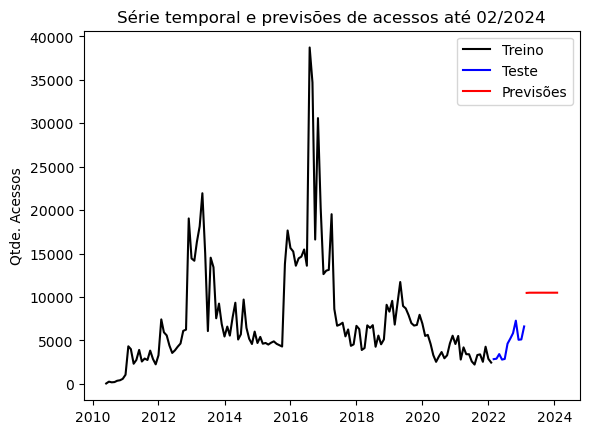

In [44]:
fig, ax = plt.subplots()
plt.ylabel('Qtde. Acessos')
plt.title('Série temporal e previsões de acessos até 02/2024')
plt.plot(trn, color='black', label='Treino')
plt.plot(tst, color='blue', label='Teste')
plt.plot(previsoes, color='red', label='Previsões')
plt.legend(bbox_to_anchor=(1, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))